In [39]:
import numpy as np
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
import warnings
warnings.filterwarnings("ignore")

In [64]:
tf.keras.backend.clear_session()

In [65]:
def load_images(data_dir):
    images = []
    labels = []
    for category in ['glioma', 'meningioma', 'notumor', 'pituitary']:
        folder_path = os.path.join(data_dir, category)
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img_resized = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA)
                    images.append(img_resized)
                    labels.append(category)
            except Exception as e:
                print(f'Error loading image {img_name}: {e}')
    return np.array(images), np.array(labels)

In [66]:
import os 
train_dir = '/Users/divyapandey/Desktop/college/Image Processing /archive (6) copy/training'
test_dir = '/Users/divyapandey/Desktop/college/Image Processing /archive (6) copy/testing'

In [67]:
x_train, y_train = load_images(train_dir)
x_test, y_test = load_images(test_dir)
print("Loaded training images:", x_train.shape)
print("Loaded testing images:", x_test.shape)


Loaded training images: (5712, 128, 128)
Loaded testing images: (1311, 128, 128)


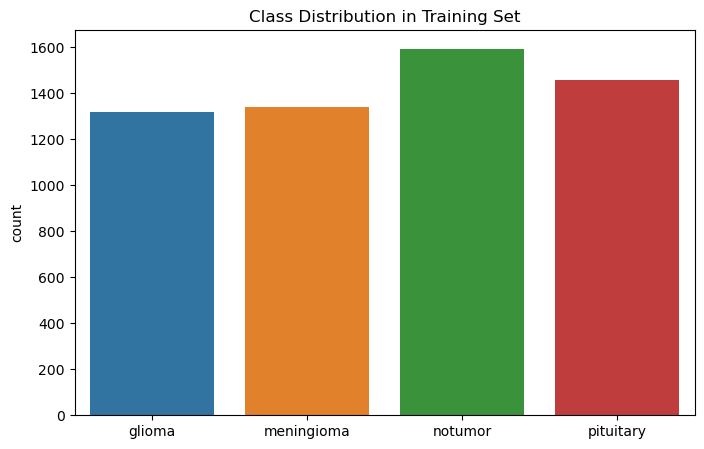

In [5]:
plt.figure(figsize=(8, 5))
sns.countplot(x=y_train)
plt.title('Class Distribution in Training Set')
plt.show()


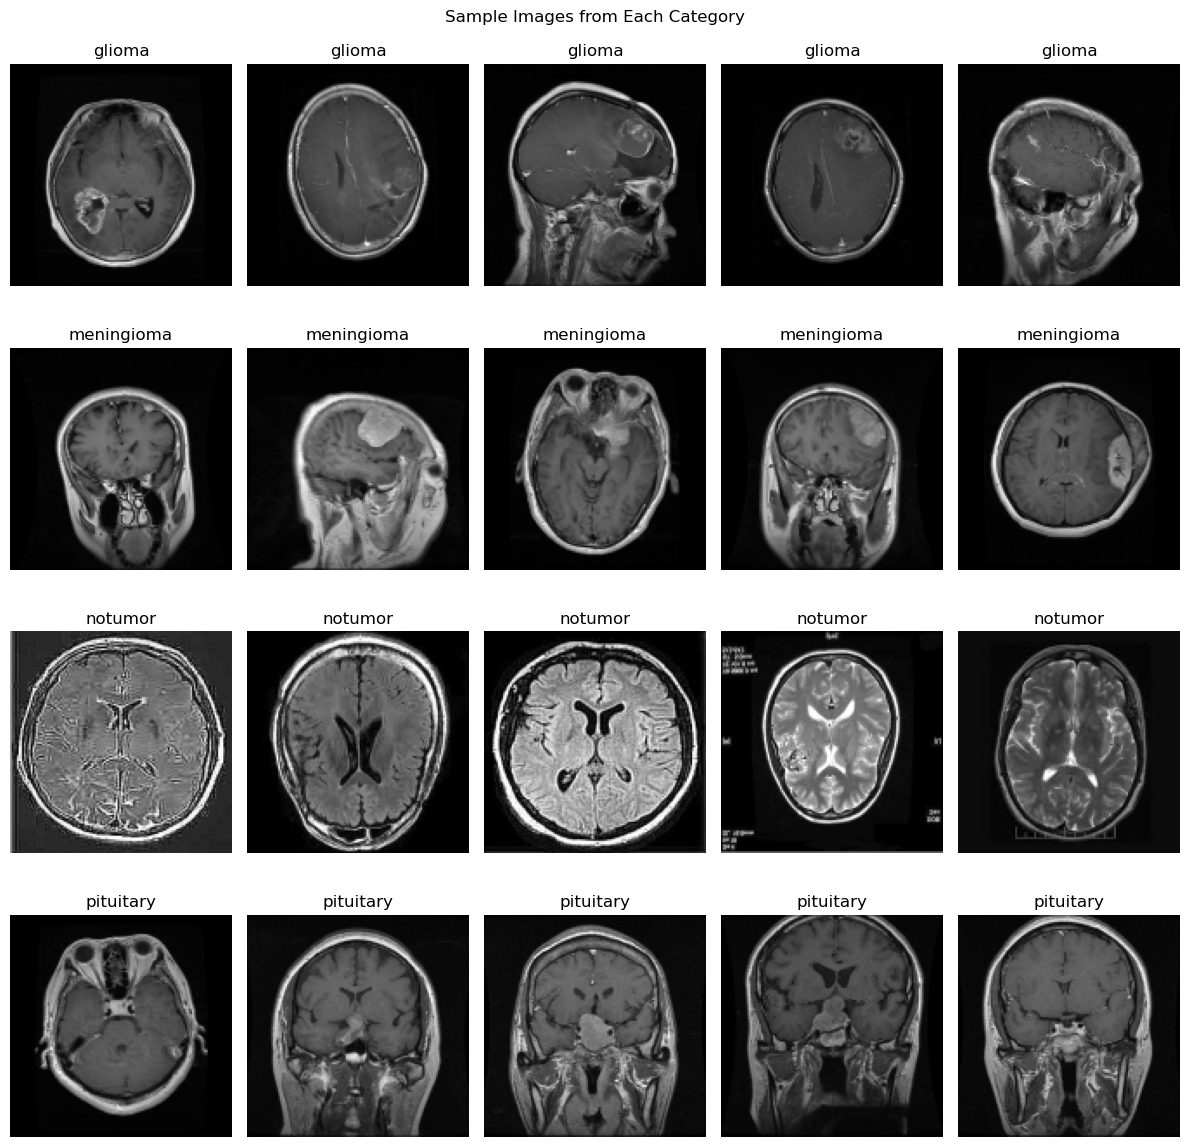

In [6]:
fig, axes = plt.subplots(4, 5, figsize=(12, 12))
fig.suptitle('Sample Images from Each Category')

for i, category in enumerate(['glioma', 'meningioma', 'notumor', 'pituitary']):
    category_images = [x_train[j] for j in range(len(y_train)) if y_train[j] == category][:5]
    for j in range(len(category_images)):
        axes[i, j].imshow(category_images[j], cmap='gray')
        axes[i, j].set_title(category)
        axes[i, j].axis('off')
plt.tight_layout()
plt.show()

In [26]:
image_shapes = [img.shape for img in x_train]
unique_shapes = set(image_shapes)
print(f'Unique image shapes in training data: {unique_shapes}')

Unique image shapes in training data: {(128, 128)}


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


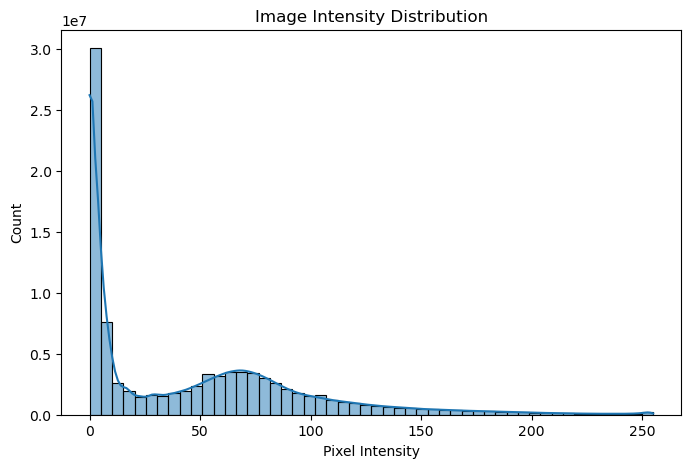

In [8]:
plt.figure(figsize=(8, 5))
flattened_images = [img.flatten() for img in x_train]
sns.histplot(np.concatenate(flattened_images), bins=50, kde=True)
plt.title('Image Intensity Distribution')
plt.xlabel('Pixel Intensity')
plt.show()

In [68]:
label_map = {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
y_train = np.array([label_map[label] for label in y_train])
y_test = np.array([label_map[label] for label in y_test])

y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

In [15]:

x_train = x_train.reshape((-1, 128, 128, 1))
x_test = x_test.reshape((-1, 128, 128, 1))


In [11]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [13]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

In [14]:
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    validation_data=(x_test, y_test),
    epochs=150,
    steps_per_epoch=len(x_train) // 32,
    verbose=1
)

Epoch 1/150


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


178/178 ━━━━━━━━━━━━━━━━━━━━ 24s 128ms/step - accuracy: 0.5399 - loss: 1.7813 - val_accuracy: 0.3135 - val_loss: 35.2392
Epoch 2/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.5625 - loss: 1.0871

2025-04-03 19:45:54.301155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5625 - loss: 1.0871 - val_accuracy: 0.3112 - val_loss: 44.1916
Epoch 3/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.5931 - loss: 0.9870 - val_accuracy: 0.7140 - val_loss: 0.9113
Epoch 4/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 22s 128ms/step - accuracy: 0.8125 - loss: 0.9118

2025-04-03 19:46:18.254635: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8125 - loss: 0.9118 - val_accuracy: 0.6865 - val_loss: 1.0248
Epoch 5/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.6421 - loss: 0.8836 - val_accuracy: 0.5545 - val_loss: 2.5893
Epoch 6/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 22s 125ms/step - accuracy: 0.6562 - loss: 0.8660

2025-04-03 19:46:42.370834: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6562 - loss: 0.8660 - val_accuracy: 0.5591 - val_loss: 2.4918
Epoch 7/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 129ms/step - accuracy: 0.6620 - loss: 0.8331 - val_accuracy: 0.7521 - val_loss: 0.8791
Epoch 8/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 22s 128ms/step - accuracy: 0.6875 - loss: 0.6865

2025-04-03 19:47:06.730487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6875 - loss: 0.6865 - val_accuracy: 0.7544 - val_loss: 0.9051
Epoch 9/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.6887 - loss: 0.7225 - val_accuracy: 0.3669 - val_loss: 19.0648
Epoch 10/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - accuracy: 0.5938 - loss: 0.7364

2025-04-03 19:47:30.752726: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5938 - loss: 0.7364 - val_accuracy: 0.3646 - val_loss: 19.1848
Epoch 11/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.6950 - loss: 0.7100 - val_accuracy: 0.7597 - val_loss: 0.6517
Epoch 12/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy: 0.7500 - loss: 0.6405

2025-04-03 19:47:54.815525: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7500 - loss: 0.6405 - val_accuracy: 0.7490 - val_loss: 0.6687
Epoch 13/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 24s 136ms/step - accuracy: 0.7062 - loss: 0.7036 - val_accuracy: 0.7239 - val_loss: 1.1283
Epoch 14/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 22s 127ms/step - accuracy: 0.7812 - loss: 0.5309

2025-04-03 19:48:20.516825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7812 - loss: 0.5309 - val_accuracy: 0.7285 - val_loss: 1.1119
Epoch 15/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 129ms/step - accuracy: 0.7342 - loss: 0.6382 - val_accuracy: 0.7742 - val_loss: 0.6631
Epoch 16/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - accuracy: 0.6562 - loss: 0.5645

2025-04-03 19:48:44.946257: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6562 - loss: 0.5645 - val_accuracy: 0.7689 - val_loss: 0.6911
Epoch 17/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.7464 - loss: 0.6299 - val_accuracy: 0.7529 - val_loss: 0.7604
Epoch 18/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 23s 132ms/step - accuracy: 0.8125 - loss: 0.5583

2025-04-03 19:49:09.218301: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8125 - loss: 0.5583 - val_accuracy: 0.7338 - val_loss: 0.8291
Epoch 19/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 126ms/step - accuracy: 0.7549 - loss: 0.6007 - val_accuracy: 0.8284 - val_loss: 0.4989
Epoch 20/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 20s 118ms/step - accuracy: 0.8438 - loss: 0.4200

2025-04-03 19:49:33.373466: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8438 - loss: 0.4200 - val_accuracy: 0.8124 - val_loss: 0.5369
Epoch 21/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.7900 - loss: 0.5380 - val_accuracy: 0.8207 - val_loss: 0.4776
Epoch 22/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy: 0.8438 - loss: 0.4343

2025-04-03 19:49:57.337785: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8438 - loss: 0.4343 - val_accuracy: 0.8230 - val_loss: 0.4807
Epoch 23/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 130ms/step - accuracy: 0.7995 - loss: 0.5280 - val_accuracy: 0.7002 - val_loss: 0.8673
Epoch 24/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 21s 123ms/step - accuracy: 0.7500 - loss: 0.4366

2025-04-03 19:50:21.866390: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7500 - loss: 0.4366 - val_accuracy: 0.7002 - val_loss: 0.8757
Epoch 25/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.8035 - loss: 0.5220 - val_accuracy: 0.6728 - val_loss: 2.4376
Epoch 26/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.8125 - loss: 0.4140

2025-04-03 19:50:45.948693: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8125 - loss: 0.4140 - val_accuracy: 0.6667 - val_loss: 2.4939
Epoch 27/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 130ms/step - accuracy: 0.8259 - loss: 0.4550 - val_accuracy: 0.6293 - val_loss: 0.7987
Epoch 28/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step - accuracy: 0.8750 - loss: 0.3567

2025-04-03 19:51:10.436674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8750 - loss: 0.3567 - val_accuracy: 0.6529 - val_loss: 0.7597
Epoch 29/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.8277 - loss: 0.4714 - val_accuracy: 0.7811 - val_loss: 0.5703
Epoch 30/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 20s 117ms/step - accuracy: 0.9062 - loss: 0.4161

2025-04-03 19:51:34.718142: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9062 - loss: 0.4161 - val_accuracy: 0.7925 - val_loss: 0.5552
Epoch 31/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.8425 - loss: 0.4374 - val_accuracy: 0.8314 - val_loss: 0.4045
Epoch 32/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.7812 - loss: 0.5020

2025-04-03 19:51:58.863830: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7812 - loss: 0.5020 - val_accuracy: 0.8375 - val_loss: 0.3840
Epoch 33/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.8439 - loss: 0.4278 - val_accuracy: 0.7567 - val_loss: 0.8760
Epoch 34/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.8438 - loss: 0.4354

2025-04-03 19:52:23.047529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8438 - loss: 0.4354 - val_accuracy: 0.7689 - val_loss: 0.7788
Epoch 35/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.8513 - loss: 0.4078 - val_accuracy: 0.7902 - val_loss: 0.7307
Epoch 36/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 22s 125ms/step - accuracy: 0.8125 - loss: 0.3928

2025-04-03 19:52:47.265208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8125 - loss: 0.3928 - val_accuracy: 0.7879 - val_loss: 0.7404
Epoch 37/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.8596 - loss: 0.3799 - val_accuracy: 0.7704 - val_loss: 0.8745
Epoch 38/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 21s 123ms/step - accuracy: 0.8438 - loss: 0.3874

2025-04-03 19:53:11.977812: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8438 - loss: 0.3874 - val_accuracy: 0.7635 - val_loss: 1.0159
Epoch 39/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 130ms/step - accuracy: 0.8536 - loss: 0.4081 - val_accuracy: 0.8406 - val_loss: 0.5099
Epoch 40/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy: 0.9375 - loss: 0.1821

2025-04-03 19:53:36.561135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 0.1821 - val_accuracy: 0.8375 - val_loss: 0.5180
Epoch 41/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 129ms/step - accuracy: 0.8633 - loss: 0.3748 - val_accuracy: 0.7925 - val_loss: 0.6654
Epoch 42/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy: 0.8750 - loss: 0.2239

2025-04-03 19:54:01.067297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8750 - loss: 0.2239 - val_accuracy: 0.7910 - val_loss: 0.6567
Epoch 43/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 129ms/step - accuracy: 0.8636 - loss: 0.3770 - val_accuracy: 0.8032 - val_loss: 0.5423
Epoch 44/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 20s 118ms/step - accuracy: 0.8125 - loss: 0.5325

2025-04-03 19:54:25.523466: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8125 - loss: 0.5325 - val_accuracy: 0.7910 - val_loss: 0.5750
Epoch 45/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 126ms/step - accuracy: 0.8681 - loss: 0.3657 - val_accuracy: 0.8017 - val_loss: 0.9263
Epoch 46/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 21s 123ms/step - accuracy: 0.8750 - loss: 0.6031

2025-04-03 19:54:49.459155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8750 - loss: 0.6031 - val_accuracy: 0.8253 - val_loss: 0.7224
Epoch 47/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.8837 - loss: 0.3374 - val_accuracy: 0.8558 - val_loss: 0.4111
Epoch 48/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.8750 - loss: 0.3825

2025-04-03 19:55:13.578425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8750 - loss: 0.3825 - val_accuracy: 0.8619 - val_loss: 0.4020
Epoch 49/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 129ms/step - accuracy: 0.8845 - loss: 0.3095 - val_accuracy: 0.8322 - val_loss: 0.4548
Epoch 50/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step - accuracy: 1.0000 - loss: 0.2787

2025-04-03 19:55:37.918537: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.2787 - val_accuracy: 0.8230 - val_loss: 0.4619
Epoch 51/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 24s 137ms/step - accuracy: 0.8823 - loss: 0.3220 - val_accuracy: 0.8215 - val_loss: 0.5728
Epoch 52/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 22s 128ms/step - accuracy: 0.7500 - loss: 0.5574

2025-04-03 19:56:03.747925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7500 - loss: 0.5574 - val_accuracy: 0.8261 - val_loss: 0.5535
Epoch 53/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.8916 - loss: 0.2926 - val_accuracy: 0.9092 - val_loss: 0.2536
Epoch 54/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step - accuracy: 0.8125 - loss: 0.5132

2025-04-03 19:56:27.999213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8125 - loss: 0.5132 - val_accuracy: 0.9047 - val_loss: 0.2540
Epoch 55/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 126ms/step - accuracy: 0.8925 - loss: 0.3006 - val_accuracy: 0.6812 - val_loss: 3.6319
Epoch 56/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.8750 - loss: 0.4046

2025-04-03 19:56:51.884328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8750 - loss: 0.4046 - val_accuracy: 0.6964 - val_loss: 3.0945
Epoch 57/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 126ms/step - accuracy: 0.8974 - loss: 0.3079 - val_accuracy: 0.9031 - val_loss: 0.2845
Epoch 58/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 20s 118ms/step - accuracy: 0.7500 - loss: 0.9573

2025-04-03 19:57:15.875123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7500 - loss: 0.9573 - val_accuracy: 0.8848 - val_loss: 0.3654
Epoch 59/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.8946 - loss: 0.3117 - val_accuracy: 0.8802 - val_loss: 0.3549
Epoch 60/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.9375 - loss: 0.2053

2025-04-03 19:57:39.900104: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 0.2053 - val_accuracy: 0.8848 - val_loss: 0.3400
Epoch 61/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 126ms/step - accuracy: 0.9021 - loss: 0.2896 - val_accuracy: 0.8185 - val_loss: 0.7037
Epoch 62/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy: 0.9062 - loss: 0.2859

2025-04-03 19:58:03.790419: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9062 - loss: 0.2859 - val_accuracy: 0.8162 - val_loss: 0.6939
Epoch 63/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 126ms/step - accuracy: 0.9153 - loss: 0.2452 - val_accuracy: 0.8063 - val_loss: 1.0498
Epoch 64/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 20s 118ms/step - accuracy: 0.8750 - loss: 0.2830

2025-04-03 19:58:27.701848: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8750 - loss: 0.2830 - val_accuracy: 0.7994 - val_loss: 1.0927
Epoch 65/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.9100 - loss: 0.2616 - val_accuracy: 0.7963 - val_loss: 0.5636
Epoch 66/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 21s 123ms/step - accuracy: 0.9375 - loss: 0.2928

2025-04-03 19:58:51.834360: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 0.2928 - val_accuracy: 0.8124 - val_loss: 0.5087
Epoch 67/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 129ms/step - accuracy: 0.9129 - loss: 0.2508 - val_accuracy: 0.8986 - val_loss: 0.2949
Epoch 68/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy: 0.8438 - loss: 0.3820

2025-04-03 19:59:16.289225: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8438 - loss: 0.3820 - val_accuracy: 0.9008 - val_loss: 0.2845
Epoch 69/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 24s 132ms/step - accuracy: 0.9152 - loss: 0.2428 - val_accuracy: 0.7010 - val_loss: 3.2508
Epoch 70/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 23s 132ms/step - accuracy: 1.0000 - loss: 0.0503

2025-04-03 19:59:41.349421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0503 - val_accuracy: 0.7010 - val_loss: 3.1888
Epoch 71/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.9123 - loss: 0.2413 - val_accuracy: 0.8017 - val_loss: 1.0707
Epoch 72/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 21s 123ms/step - accuracy: 0.8125 - loss: 0.6137

2025-04-03 20:00:05.569027: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8125 - loss: 0.6137 - val_accuracy: 0.7925 - val_loss: 1.2799
Epoch 73/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.9167 - loss: 0.2326 - val_accuracy: 0.9291 - val_loss: 0.2142
Epoch 74/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy: 1.0000 - loss: 0.0616

2025-04-03 20:00:29.845065: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0616 - val_accuracy: 0.9291 - val_loss: 0.2113
Epoch 75/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.9184 - loss: 0.2408 - val_accuracy: 0.8185 - val_loss: 1.6459
Epoch 76/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.7812 - loss: 0.4518

2025-04-03 20:00:54.084901: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7812 - loss: 0.4518 - val_accuracy: 0.8330 - val_loss: 1.3795
Epoch 77/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.9288 - loss: 0.2095 - val_accuracy: 0.8749 - val_loss: 0.6308
Epoch 78/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 20s 118ms/step - accuracy: 0.9375 - loss: 0.1245

2025-04-03 20:01:18.308332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 0.1245 - val_accuracy: 0.8802 - val_loss: 0.6065
Epoch 79/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.9253 - loss: 0.2077 - val_accuracy: 0.8909 - val_loss: 0.3747
Epoch 80/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy: 0.9375 - loss: 0.2151

2025-04-03 20:01:42.337206: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 0.2151 - val_accuracy: 0.8932 - val_loss: 0.3676
Epoch 81/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.9254 - loss: 0.2005 - val_accuracy: 0.8505 - val_loss: 0.7672
Epoch 82/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 20s 118ms/step - accuracy: 0.9062 - loss: 0.2478

2025-04-03 20:02:06.395843: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9062 - loss: 0.2478 - val_accuracy: 0.8490 - val_loss: 0.8739
Epoch 83/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy: 0.9256 - loss: 0.2122 - val_accuracy: 0.8513 - val_loss: 0.5100
Epoch 84/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 23s 133ms/step - accuracy: 1.0000 - loss: 0.0229

2025-04-03 20:02:30.185646: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0229 - val_accuracy: 0.8330 - val_loss: 0.5422
Epoch 85/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.9217 - loss: 0.2298 - val_accuracy: 0.9123 - val_loss: 0.4202
Epoch 86/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.9688 - loss: 0.1012

2025-04-03 20:02:54.567791: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9688 - loss: 0.1012 - val_accuracy: 0.9161 - val_loss: 0.3853
Epoch 87/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - accuracy: 0.9330 - loss: 0.1909 - val_accuracy: 0.9405 - val_loss: 0.1752
Epoch 88/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 24s 140ms/step - accuracy: 0.9062 - loss: 0.2155

2025-04-03 20:03:19.872971: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9062 - loss: 0.2155 - val_accuracy: 0.9390 - val_loss: 0.1780
Epoch 89/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 24s 133ms/step - accuracy: 0.9334 - loss: 0.1904 - val_accuracy: 0.8703 - val_loss: 0.6665
Epoch 90/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 22s 127ms/step - accuracy: 0.9688 - loss: 0.1651

2025-04-03 20:03:45.048922: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9688 - loss: 0.1651 - val_accuracy: 0.8749 - val_loss: 0.6140
Epoch 91/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9352 - loss: 0.2008 - val_accuracy: 0.8894 - val_loss: 0.4319
Epoch 92/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy: 0.9375 - loss: 0.1740

2025-04-03 20:04:09.976039: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 0.1740 - val_accuracy: 0.8871 - val_loss: 0.4292
Epoch 93/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.9299 - loss: 0.2118 - val_accuracy: 0.9062 - val_loss: 0.3305
Epoch 94/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.9375 - loss: 0.2138

2025-04-03 20:04:34.338296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 0.2138 - val_accuracy: 0.8818 - val_loss: 0.4591
Epoch 95/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.9320 - loss: 0.1936 - val_accuracy: 0.9047 - val_loss: 0.3240
Epoch 96/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 21s 123ms/step - accuracy: 0.8750 - loss: 0.2268

2025-04-03 20:04:58.495865: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8750 - loss: 0.2268 - val_accuracy: 0.9031 - val_loss: 0.3468
Epoch 97/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.9352 - loss: 0.1922 - val_accuracy: 0.7292 - val_loss: 3.3508
Epoch 98/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 22s 125ms/step - accuracy: 0.9375 - loss: 0.1607

2025-04-03 20:05:22.712072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 0.1607 - val_accuracy: 0.7338 - val_loss: 3.1447
Epoch 99/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 130ms/step - accuracy: 0.9394 - loss: 0.1773 - val_accuracy: 0.8459 - val_loss: 1.2681
Epoch 100/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 1.0000 - loss: 0.0170

2025-04-03 20:05:47.324288: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0170 - val_accuracy: 0.8452 - val_loss: 1.1199
Epoch 101/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.9397 - loss: 0.1841 - val_accuracy: 0.8955 - val_loss: 0.2807
Epoch 102/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step - accuracy: 0.9062 - loss: 0.2618

2025-04-03 20:06:11.603038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9062 - loss: 0.2618 - val_accuracy: 0.8993 - val_loss: 0.2729
Epoch 103/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.9345 - loss: 0.1865 - val_accuracy: 0.8963 - val_loss: 0.4146
Epoch 104/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy: 0.9062 - loss: 0.1759

2025-04-03 20:06:35.894454: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9062 - loss: 0.1759 - val_accuracy: 0.8924 - val_loss: 0.4194
Epoch 105/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.9445 - loss: 0.1683 - val_accuracy: 0.9268 - val_loss: 0.2089
Epoch 106/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.9062 - loss: 0.1988

2025-04-03 20:07:00.115191: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9062 - loss: 0.1988 - val_accuracy: 0.9260 - val_loss: 0.2138
Epoch 107/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.9499 - loss: 0.1487 - val_accuracy: 0.9314 - val_loss: 0.1790
Epoch 108/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 22s 127ms/step - accuracy: 1.0000 - loss: 0.0448

2025-04-03 20:07:24.453076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0448 - val_accuracy: 0.9336 - val_loss: 0.1799
Epoch 109/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.9491 - loss: 0.1531 - val_accuracy: 0.9321 - val_loss: 0.3487
Epoch 110/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 22s 125ms/step - accuracy: 0.9375 - loss: 0.1653

2025-04-03 20:07:48.600009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 0.1653 - val_accuracy: 0.9283 - val_loss: 0.3778
Epoch 111/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.9465 - loss: 0.1577 - val_accuracy: 0.9382 - val_loss: 0.3334
Epoch 112/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.9375 - loss: 0.1148

2025-04-03 20:08:12.903164: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 0.1148 - val_accuracy: 0.9306 - val_loss: 0.4285
Epoch 113/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.9469 - loss: 0.1533 - val_accuracy: 0.7506 - val_loss: 0.5768
Epoch 114/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy: 0.9062 - loss: 0.2756

2025-04-03 20:08:37.071246: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9062 - loss: 0.2756 - val_accuracy: 0.7468 - val_loss: 0.5671
Epoch 115/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.9434 - loss: 0.1709 - val_accuracy: 0.9085 - val_loss: 0.4561
Epoch 116/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 22s 127ms/step - accuracy: 0.9375 - loss: 0.1216

2025-04-03 20:09:01.184323: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 0.1216 - val_accuracy: 0.9115 - val_loss: 0.4166
Epoch 117/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.9412 - loss: 0.1546 - val_accuracy: 0.9336 - val_loss: 0.1932
Epoch 118/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - accuracy: 0.8750 - loss: 0.3226

2025-04-03 20:09:25.254466: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8750 - loss: 0.3226 - val_accuracy: 0.9397 - val_loss: 0.1855
Epoch 119/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.9567 - loss: 0.1325 - val_accuracy: 0.9596 - val_loss: 0.1457
Epoch 120/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 22s 125ms/step - accuracy: 0.8750 - loss: 0.4706

2025-04-03 20:09:49.303263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8750 - loss: 0.4706 - val_accuracy: 0.9580 - val_loss: 0.1486
Epoch 121/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 129ms/step - accuracy: 0.9513 - loss: 0.1422 - val_accuracy: 0.9413 - val_loss: 0.2151
Epoch 122/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 22s 125ms/step - accuracy: 1.0000 - loss: 0.0622

2025-04-03 20:10:13.624297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0622 - val_accuracy: 0.9375 - val_loss: 0.2220
Epoch 123/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.9529 - loss: 0.1465 - val_accuracy: 0.9443 - val_loss: 0.3279
Epoch 124/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - accuracy: 0.9688 - loss: 0.1009

2025-04-03 20:10:37.789850: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9688 - loss: 0.1009 - val_accuracy: 0.9382 - val_loss: 0.3912
Epoch 125/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 129ms/step - accuracy: 0.9476 - loss: 0.1586 - val_accuracy: 0.9504 - val_loss: 0.1730
Epoch 126/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 22s 127ms/step - accuracy: 1.0000 - loss: 0.0335

2025-04-03 20:11:02.325143: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0335 - val_accuracy: 0.9474 - val_loss: 0.1876
Epoch 127/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.9467 - loss: 0.1648 - val_accuracy: 0.9580 - val_loss: 0.1522
Epoch 128/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 21s 123ms/step - accuracy: 0.9062 - loss: 0.2138

2025-04-03 20:11:26.688524: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9062 - loss: 0.2138 - val_accuracy: 0.9580 - val_loss: 0.1575
Epoch 129/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.9534 - loss: 0.1390 - val_accuracy: 0.9199 - val_loss: 0.2296
Epoch 130/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - accuracy: 0.9062 - loss: 0.1686

2025-04-03 20:11:50.692032: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9062 - loss: 0.1686 - val_accuracy: 0.9260 - val_loss: 0.2087
Epoch 131/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.9469 - loss: 0.1678 - val_accuracy: 0.8848 - val_loss: 0.7106
Epoch 132/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 21s 123ms/step - accuracy: 1.0000 - loss: 0.0435

2025-04-03 20:12:14.878044: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0435 - val_accuracy: 0.8825 - val_loss: 0.7815
Epoch 133/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.9493 - loss: 0.1537 - val_accuracy: 0.9428 - val_loss: 0.2550
Epoch 134/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.9375 - loss: 0.1278

2025-04-03 20:12:39.188220: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 0.1278 - val_accuracy: 0.9413 - val_loss: 0.3126
Epoch 135/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.9508 - loss: 0.1474 - val_accuracy: 0.9245 - val_loss: 0.2659
Epoch 136/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 31s 176ms/step - accuracy: 0.9688 - loss: 0.1569

2025-04-03 20:13:03.381336: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9688 - loss: 0.1569 - val_accuracy: 0.9237 - val_loss: 0.2688
Epoch 137/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 129ms/step - accuracy: 0.9552 - loss: 0.1316 - val_accuracy: 0.8047 - val_loss: 1.7264
Epoch 138/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step - accuracy: 0.9062 - loss: 0.1404

2025-04-03 20:13:27.772585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9062 - loss: 0.1404 - val_accuracy: 0.7689 - val_loss: 2.7461
Epoch 139/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.9583 - loss: 0.1269 - val_accuracy: 0.9268 - val_loss: 0.2815
Epoch 140/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy: 0.9062 - loss: 0.3454

2025-04-03 20:13:51.877750: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9062 - loss: 0.3454 - val_accuracy: 0.9237 - val_loss: 0.3066
Epoch 141/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.9556 - loss: 0.1283 - val_accuracy: 0.8963 - val_loss: 0.4604
Epoch 142/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.9375 - loss: 0.1377

2025-04-03 20:14:16.016702: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 0.1377 - val_accuracy: 0.8970 - val_loss: 0.4482
Epoch 143/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.9547 - loss: 0.1421 - val_accuracy: 0.9291 - val_loss: 0.2395
Epoch 144/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy: 0.9688 - loss: 0.2120

2025-04-03 20:14:40.235063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9688 - loss: 0.2120 - val_accuracy: 0.9390 - val_loss: 0.2194
Epoch 145/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.9553 - loss: 0.1331 - val_accuracy: 0.8894 - val_loss: 0.5330
Epoch 146/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - accuracy: 0.9688 - loss: 0.1478

2025-04-03 20:15:04.504049: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9688 - loss: 0.1478 - val_accuracy: 0.8871 - val_loss: 0.5351
Epoch 147/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 129ms/step - accuracy: 0.9576 - loss: 0.1337 - val_accuracy: 0.9565 - val_loss: 0.1185
Epoch 148/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.9688 - loss: 0.1079

2025-04-03 20:15:28.908576: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9688 - loss: 0.1079 - val_accuracy: 0.9535 - val_loss: 0.1305
Epoch 149/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.9568 - loss: 0.1345 - val_accuracy: 0.8177 - val_loss: 3.2579
Epoch 150/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 21s 123ms/step - accuracy: 0.9375 - loss: 0.2020

2025-04-03 20:15:53.153494: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 0.2020 - val_accuracy: 0.8200 - val_loss: 3.0881


In [15]:
model.save('brain_tumor_detection_model.h5')

In [16]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7852 - loss: 3.2220
Test Accuracy: 82.00%


In [17]:
def plot_training_history(history):
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

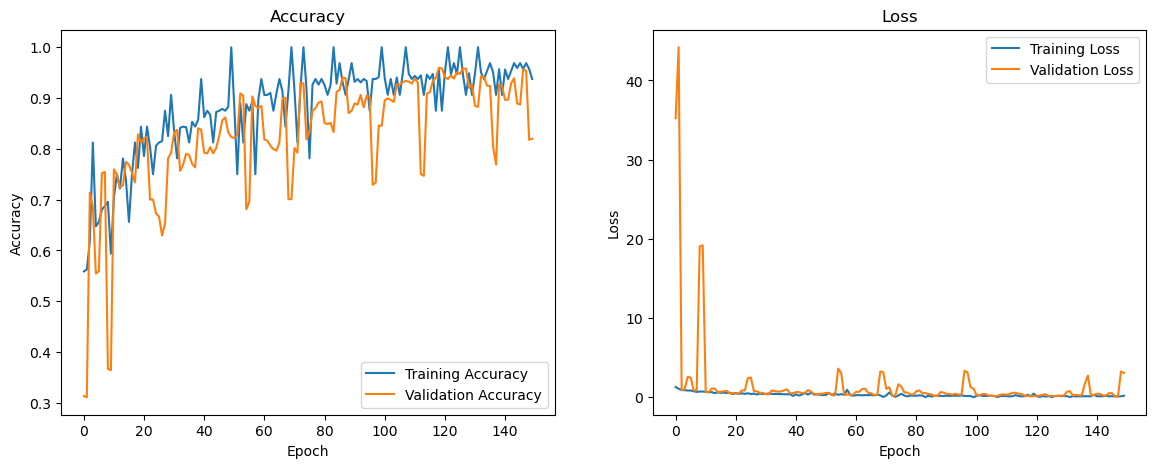

In [18]:
plot_training_history(history)

In [19]:
y_pred = np.argmax(model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


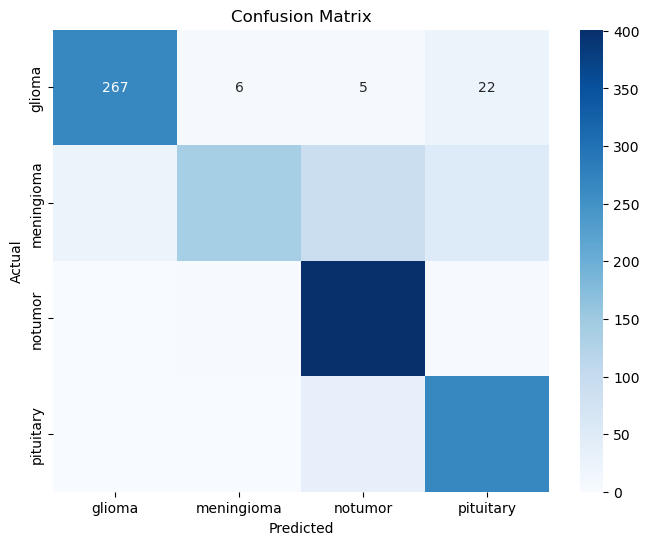

In [20]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [21]:
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=label_map.keys()))



Classification Report:
               precision    recall  f1-score   support

      glioma       0.92      0.89      0.91       300
  meningioma       0.95      0.46      0.62       306
     notumor       0.76      0.99      0.86       405
   pituitary       0.78      0.89      0.83       300

    accuracy                           0.82      1311
   macro avg       0.85      0.81      0.80      1311
weighted avg       0.84      0.82      0.81      1311



In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [23]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1), kernel_regularizer='l2'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer='l2'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer='l2'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Conv2D(256, (3, 3), activation='relu', kernel_regularizer='l2'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.5),

    Flatten(),
    Dense(512, activation='relu', kernel_regularizer='l2'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
]

In [25]:
datagen = ImageDataGenerator(
    rotation_range=40,
    zoom_range=0.3,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
datagen.fit(x_train)

In [26]:
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    validation_data=(x_test, y_test),
    epochs=150,
    steps_per_epoch=len(x_train) // 32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/150


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


178/178 ━━━━━━━━━━━━━━━━━━━━ 37s 201ms/step - accuracy: 0.4511 - loss: 14.7048 - val_accuracy: 0.4508 - val_loss: 8.4799 - learning_rate: 0.0010
Epoch 2/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 34s 195ms/step - accuracy: 0.5938 - loss: 7.5993

2025-04-03 20:16:34.609574: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5938 - loss: 7.5993 - val_accuracy: 0.4477 - val_loss: 8.4657 - learning_rate: 0.0010
Epoch 3/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 35s 198ms/step - accuracy: 0.5211 - loss: 6.5579 - val_accuracy: 0.3928 - val_loss: 8.4486 - learning_rate: 0.0010
Epoch 4/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 33s 190ms/step - accuracy: 0.5938 - loss: 4.5723

2025-04-03 20:17:11.899310: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5938 - loss: 4.5723 - val_accuracy: 0.3936 - val_loss: 8.2479 - learning_rate: 0.0010
Epoch 5/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 36s 202ms/step - accuracy: 0.5366 - loss: 4.3594 - val_accuracy: 0.4477 - val_loss: 6.5655 - learning_rate: 0.0010
Epoch 6/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 34s 196ms/step - accuracy: 0.5938 - loss: 4.0071

2025-04-03 20:17:49.840720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5938 - loss: 4.0071 - val_accuracy: 0.4661 - val_loss: 6.6504 - learning_rate: 0.0010
Epoch 7/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 35s 198ms/step - accuracy: 0.5616 - loss: 3.4328 - val_accuracy: 0.4020 - val_loss: 3.8531 - learning_rate: 0.0010
Epoch 8/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 32s 185ms/step - accuracy: 0.5625 - loss: 2.6969

2025-04-03 20:18:27.081199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5625 - loss: 2.6969 - val_accuracy: 0.4081 - val_loss: 3.7964 - learning_rate: 0.0010
Epoch 9/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 36s 199ms/step - accuracy: 0.5842 - loss: 2.7830 - val_accuracy: 0.4378 - val_loss: 2.9146 - learning_rate: 0.0010
Epoch 10/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 33s 188ms/step - accuracy: 0.6562 - loss: 2.1553

2025-04-03 20:19:04.465600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6562 - loss: 2.1553 - val_accuracy: 0.5004 - val_loss: 2.8122 - learning_rate: 0.0010
Epoch 11/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 36s 199ms/step - accuracy: 0.6066 - loss: 2.3099 - val_accuracy: 0.3158 - val_loss: 4.2466 - learning_rate: 0.0010
Epoch 12/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 33s 190ms/step - accuracy: 0.5000 - loss: 2.9696

2025-04-03 20:19:41.876009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5000 - loss: 2.9696 - val_accuracy: 0.3265 - val_loss: 3.9759 - learning_rate: 0.0010
Epoch 13/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 36s 199ms/step - accuracy: 0.6070 - loss: 2.4639 - val_accuracy: 0.4172 - val_loss: 5.1265 - learning_rate: 0.0010
Epoch 14/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 34s 196ms/step - accuracy: 0.4062 - loss: 2.4081

2025-04-03 20:20:19.313453: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4062 - loss: 2.4081 - val_accuracy: 0.4233 - val_loss: 4.9419 - learning_rate: 0.0010
Epoch 15/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 36s 199ms/step - accuracy: 0.6259 - loss: 2.0185 - val_accuracy: 0.5355 - val_loss: 2.2258 - learning_rate: 0.0010
Epoch 16/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 34s 195ms/step - accuracy: 0.7188 - loss: 1.7105

2025-04-03 20:20:56.681986: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7188 - loss: 1.7105 - val_accuracy: 0.5339 - val_loss: 2.2042 - learning_rate: 0.0010
Epoch 17/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 37s 206ms/step - accuracy: 0.6504 - loss: 1.8884 - val_accuracy: 0.3333 - val_loss: 3.4593 - learning_rate: 0.0010
Epoch 18/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 34s 194ms/step - accuracy: 0.5938 - loss: 1.8575

2025-04-03 20:21:35.418007: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5938 - loss: 1.8575 - val_accuracy: 0.3547 - val_loss: 3.2714 - learning_rate: 0.0010
Epoch 19/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 36s 202ms/step - accuracy: 0.6790 - loss: 1.7477 - val_accuracy: 0.4722 - val_loss: 3.5450 - learning_rate: 0.0010
Epoch 20/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 38s 218ms/step - accuracy: 0.6250 - loss: 1.8829

2025-04-03 20:22:13.443078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6250 - loss: 1.8829 - val_accuracy: 0.4867 - val_loss: 3.5218 - learning_rate: 0.0010
Epoch 21/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.6774 - loss: 1.7143
Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
178/178 ━━━━━━━━━━━━━━━━━━━━ 36s 199ms/step - accuracy: 0.6774 - loss: 1.7142 - val_accuracy: 0.4165 - val_loss: 4.2913 - learning_rate: 0.0010
Epoch 22/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 32s 186ms/step - accuracy: 0.5312 - loss: 1.8954

2025-04-03 20:22:50.968349: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5312 - loss: 1.8954 - val_accuracy: 0.4180 - val_loss: 4.2289 - learning_rate: 5.0000e-04
Epoch 23/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 37s 210ms/step - accuracy: 0.7325 - loss: 1.4733 - val_accuracy: 0.5721 - val_loss: 1.6322 - learning_rate: 5.0000e-04
Epoch 24/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 34s 196ms/step - accuracy: 0.7812 - loss: 1.1933

2025-04-03 20:23:30.252967: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7812 - loss: 1.1933 - val_accuracy: 0.5652 - val_loss: 1.6955 - learning_rate: 5.0000e-04
Epoch 25/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 35s 198ms/step - accuracy: 0.7560 - loss: 1.1842 - val_accuracy: 0.7140 - val_loss: 1.2508 - learning_rate: 5.0000e-04
Epoch 26/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 33s 188ms/step - accuracy: 0.7188 - loss: 1.3452

2025-04-03 20:24:07.489145: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7188 - loss: 1.3452 - val_accuracy: 0.6972 - val_loss: 1.3197 - learning_rate: 5.0000e-04
Epoch 27/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 36s 202ms/step - accuracy: 0.7758 - loss: 1.1327 - val_accuracy: 0.5553 - val_loss: 2.6093 - learning_rate: 5.0000e-04
Epoch 28/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 33s 191ms/step - accuracy: 0.8438 - loss: 0.8625

2025-04-03 20:24:45.559833: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8438 - loss: 0.8625 - val_accuracy: 0.5667 - val_loss: 2.4703 - learning_rate: 5.0000e-04
Epoch 29/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 36s 199ms/step - accuracy: 0.7664 - loss: 1.1518 - val_accuracy: 0.5477 - val_loss: 1.8045 - learning_rate: 5.0000e-04
Epoch 30/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 32s 185ms/step - accuracy: 0.9375 - loss: 0.9204

2025-04-03 20:25:22.927636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9375 - loss: 0.9204 - val_accuracy: 0.5431 - val_loss: 1.8183 - learning_rate: 5.0000e-04
Epoch 31/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 36s 201ms/step - accuracy: 0.7940 - loss: 1.0669 - val_accuracy: 0.6201 - val_loss: 1.8353 - learning_rate: 2.5000e-04
Epoch 32/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 33s 187ms/step - accuracy: 0.7812 - loss: 1.0081

2025-04-03 20:26:00.576986: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7812 - loss: 1.0081 - val_accuracy: 0.6316 - val_loss: 1.7353 - learning_rate: 2.5000e-04
Epoch 33/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 36s 200ms/step - accuracy: 0.8100 - loss: 0.9172 - val_accuracy: 0.7086 - val_loss: 1.1863 - learning_rate: 2.5000e-04
Epoch 34/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 32s 186ms/step - accuracy: 0.8750 - loss: 0.9816

2025-04-03 20:26:38.122659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8750 - loss: 0.9816 - val_accuracy: 0.7033 - val_loss: 1.1914 - learning_rate: 2.5000e-04
Epoch 35/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 35s 198ms/step - accuracy: 0.8128 - loss: 0.8867 - val_accuracy: 0.6285 - val_loss: 1.8576 - learning_rate: 2.5000e-04
Epoch 36/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 34s 192ms/step - accuracy: 0.9375 - loss: 0.6109

2025-04-03 20:27:15.284110: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9375 - loss: 0.6109 - val_accuracy: 0.6316 - val_loss: 1.8446 - learning_rate: 2.5000e-04
Epoch 37/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 36s 199ms/step - accuracy: 0.8327 - loss: 0.8349 - val_accuracy: 0.8101 - val_loss: 0.9145 - learning_rate: 2.5000e-04
Epoch 38/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 35s 199ms/step - accuracy: 0.9062 - loss: 0.7716

2025-04-03 20:27:52.746965: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9062 - loss: 0.7716 - val_accuracy: 0.8055 - val_loss: 0.9353 - learning_rate: 2.5000e-04
Epoch 39/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 35s 197ms/step - accuracy: 0.8325 - loss: 0.8432 - val_accuracy: 0.7613 - val_loss: 1.0514 - learning_rate: 2.5000e-04
Epoch 40/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 33s 188ms/step - accuracy: 0.8438 - loss: 0.7676

2025-04-03 20:28:29.776718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8438 - loss: 0.7676 - val_accuracy: 0.7597 - val_loss: 1.0696 - learning_rate: 2.5000e-04
Epoch 41/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 35s 198ms/step - accuracy: 0.8418 - loss: 0.8292 - val_accuracy: 0.7834 - val_loss: 1.0278 - learning_rate: 2.5000e-04
Epoch 42/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 34s 195ms/step - accuracy: 0.7812 - loss: 0.9100

2025-04-03 20:29:07.016768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 42: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7812 - loss: 0.9100 - val_accuracy: 0.7872 - val_loss: 1.0323 - learning_rate: 2.5000e-04
Epoch 43/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 35s 197ms/step - accuracy: 0.8503 - loss: 0.8197 - val_accuracy: 0.7765 - val_loss: 0.9858 - learning_rate: 1.2500e-04
Epoch 44/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 33s 190ms/step - accuracy: 0.8438 - loss: 0.7609

2025-04-03 20:29:44.098677: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8438 - loss: 0.7609 - val_accuracy: 0.7765 - val_loss: 0.9810 - learning_rate: 1.2500e-04
Epoch 45/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 35s 197ms/step - accuracy: 0.8562 - loss: 0.7280 - val_accuracy: 0.6857 - val_loss: 1.4801 - learning_rate: 1.2500e-04
Epoch 46/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 33s 189ms/step - accuracy: 0.8438 - loss: 0.6213

2025-04-03 20:30:21.118797: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8438 - loss: 0.6213 - val_accuracy: 0.6796 - val_loss: 1.5079 - learning_rate: 1.2500e-04
Epoch 47/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 35s 197ms/step - accuracy: 0.8630 - loss: 0.6943 - val_accuracy: 0.8688 - val_loss: 0.6663 - learning_rate: 1.2500e-04
Epoch 48/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 32s 184ms/step - accuracy: 0.9688 - loss: 0.4662

2025-04-03 20:30:58.093457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9688 - loss: 0.4662 - val_accuracy: 0.8673 - val_loss: 0.6716 - learning_rate: 1.2500e-04
Epoch 49/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 35s 197ms/step - accuracy: 0.8627 - loss: 0.6841 - val_accuracy: 0.8192 - val_loss: 0.8333 - learning_rate: 1.2500e-04
Epoch 50/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 33s 189ms/step - accuracy: 0.9062 - loss: 0.5774

2025-04-03 20:31:35.209919: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9062 - loss: 0.5774 - val_accuracy: 0.8299 - val_loss: 0.8109 - learning_rate: 1.2500e-04
Epoch 51/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 35s 196ms/step - accuracy: 0.8642 - loss: 0.6623 - val_accuracy: 0.8154 - val_loss: 0.7844 - learning_rate: 1.2500e-04
Epoch 52/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 32s 184ms/step - accuracy: 0.7812 - loss: 0.6329

2025-04-03 20:32:12.161435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 52: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7812 - loss: 0.6329 - val_accuracy: 0.8253 - val_loss: 0.7529 - learning_rate: 1.2500e-04
Epoch 53/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 35s 196ms/step - accuracy: 0.8801 - loss: 0.6369 - val_accuracy: 0.8322 - val_loss: 0.7443 - learning_rate: 6.2500e-05
Epoch 54/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 34s 196ms/step - accuracy: 0.9062 - loss: 0.5639

2025-04-03 20:32:48.990344: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9062 - loss: 0.5639 - val_accuracy: 0.8268 - val_loss: 0.7541 - learning_rate: 6.2500e-05
Epoch 55/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 35s 197ms/step - accuracy: 0.8810 - loss: 0.6003 - val_accuracy: 0.8284 - val_loss: 0.7409 - learning_rate: 6.2500e-05
Epoch 56/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 34s 193ms/step - accuracy: 0.8125 - loss: 0.6932

2025-04-03 20:33:26.080235: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8125 - loss: 0.6932 - val_accuracy: 0.8246 - val_loss: 0.7483 - learning_rate: 6.2500e-05
Epoch 57/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 35s 198ms/step - accuracy: 0.8912 - loss: 0.5774 - val_accuracy: 0.8703 - val_loss: 0.6242 - learning_rate: 6.2500e-05
Epoch 58/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - accuracy: 0.9375 - loss: 0.4510

2025-04-03 20:34:03.185406: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9375 - loss: 0.4510 - val_accuracy: 0.8726 - val_loss: 0.6206 - learning_rate: 6.2500e-05
Epoch 59/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 35s 198ms/step - accuracy: 0.8851 - loss: 0.5556 - val_accuracy: 0.8337 - val_loss: 0.6994 - learning_rate: 6.2500e-05
Epoch 60/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 32s 185ms/step - accuracy: 0.8750 - loss: 0.6530

2025-04-03 20:34:40.433940: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8750 - loss: 0.6530 - val_accuracy: 0.8230 - val_loss: 0.7126 - learning_rate: 6.2500e-05
Epoch 61/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 35s 199ms/step - accuracy: 0.8983 - loss: 0.5302 - val_accuracy: 0.8009 - val_loss: 0.8046 - learning_rate: 6.2500e-05
Epoch 62/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 19s 111ms/step - accuracy: 0.6875 - loss: 0.8136

2025-04-03 20:35:17.646555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6875 - loss: 0.8136 - val_accuracy: 0.7979 - val_loss: 0.8143 - learning_rate: 6.2500e-05
Epoch 63/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.8853 - loss: 0.5581
Epoch 63: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
178/178 ━━━━━━━━━━━━━━━━━━━━ 35s 198ms/step - accuracy: 0.8854 - loss: 0.5580 - val_accuracy: 0.8543 - val_loss: 0.6218 - learning_rate: 6.2500e-05
Epoch 64/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 33s 191ms/step - accuracy: 0.8750 - loss: 0.4938

2025-04-03 20:35:54.884074: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8750 - loss: 0.4938 - val_accuracy: 0.8551 - val_loss: 0.6215 - learning_rate: 3.1250e-05
Epoch 65/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 35s 198ms/step - accuracy: 0.8984 - loss: 0.5077 - val_accuracy: 0.8253 - val_loss: 0.6758 - learning_rate: 3.1250e-05
Epoch 66/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 33s 190ms/step - accuracy: 0.8438 - loss: 0.6180

2025-04-03 20:36:32.080622: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8438 - loss: 0.6180 - val_accuracy: 0.8238 - val_loss: 0.6762 - learning_rate: 3.1250e-05
Epoch 67/150
178/178 ━━━━━━━━━━━━━━━━━━━━ 36s 203ms/step - accuracy: 0.9005 - loss: 0.5103 - val_accuracy: 0.8467 - val_loss: 0.6370 - learning_rate: 3.1250e-05
Epoch 68/150
  1/178 ━━━━━━━━━━━━━━━━━━━━ 32s 184ms/step - accuracy: 0.9375 - loss: 0.4319

2025-04-03 20:37:10.201151: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 68: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9375 - loss: 0.4319 - val_accuracy: 0.8513 - val_loss: 0.6314 - learning_rate: 3.1250e-05


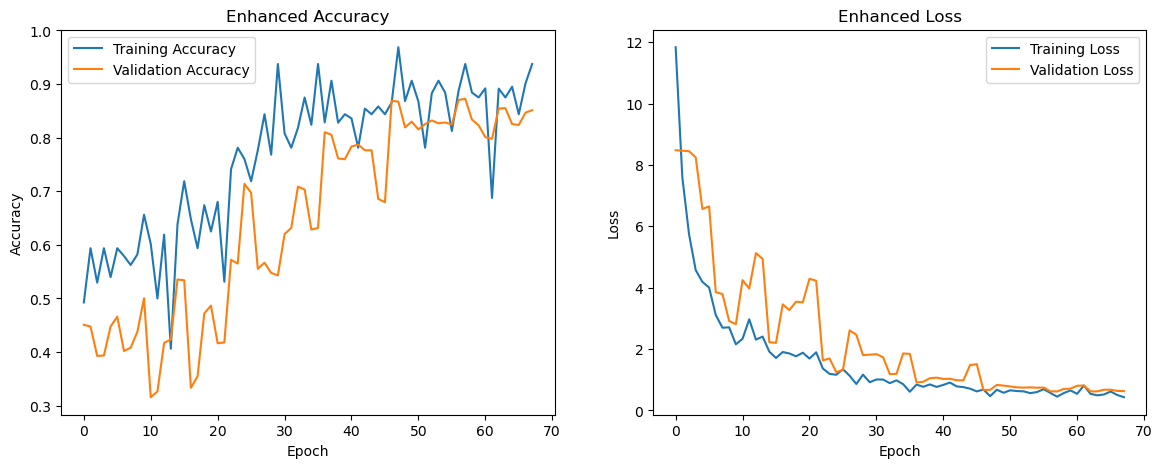

In [27]:
def plot_training_history(history):
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Enhanced Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Enhanced Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_training_history(history)

In [28]:
y_pred = np.argmax(model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step


In [29]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['glioma', 'meningioma', 'notumor', 'pituitary']))


Classification Report:
              precision    recall  f1-score   support

      glioma       0.93      0.87      0.90       300
  meningioma       0.92      0.61      0.73       306
     notumor       0.90      0.99      0.94       405
   pituitary       0.78      1.00      0.87       300

    accuracy                           0.87      1311
   macro avg       0.88      0.86      0.86      1311
weighted avg       0.88      0.87      0.87      1311



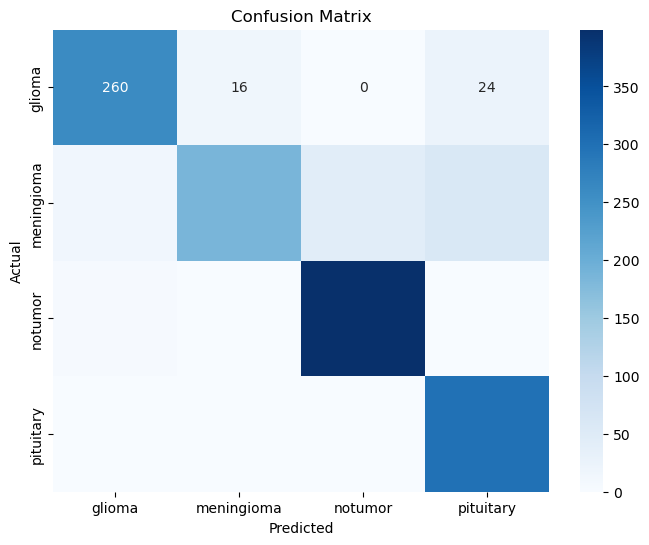

In [30]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['glioma', 'meningioma', 'notumor', 'pituitary'], yticklabels=['glioma', 'meningioma', 'notumor', 'pituitary'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

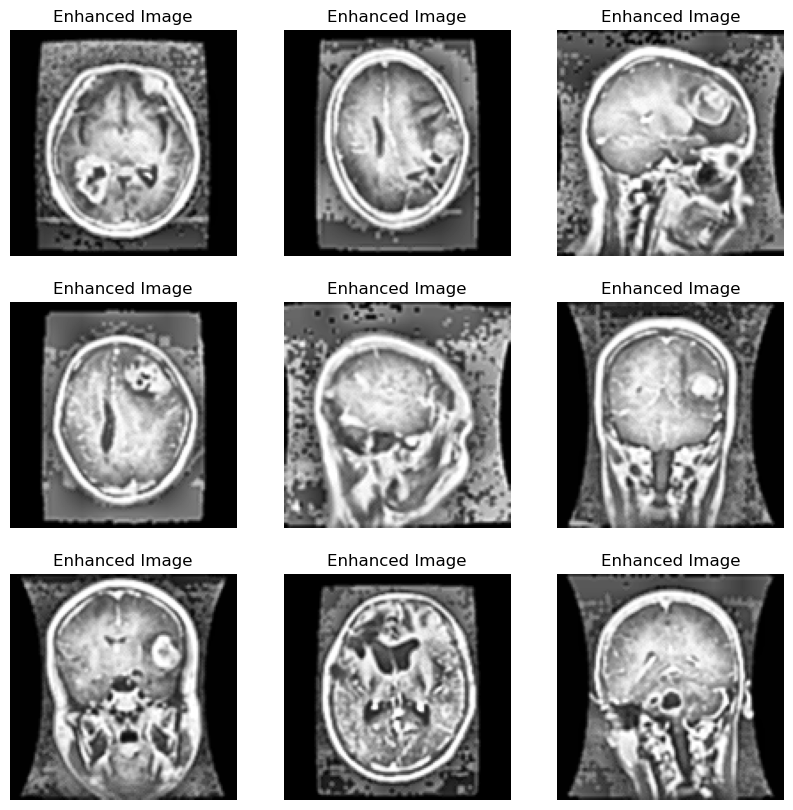

In [67]:
def enhance_image(image):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    equalized = cv2.equalizeHist(image)

    blurred = cv2.GaussianBlur(equalized, (5, 5), 0)

    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    sharpened = cv2.filter2D(blurred, -1, kernel)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(sharpened)

    return enhanced

x_train_enhanced = np.array([enhance_image(img) for img in x_train.squeeze()])
x_test_enhanced = np.array([enhance_image(img) for img in x_test.squeeze()])

x_train_enhanced = x_train_enhanced.reshape((-1, 128, 128, 1))
x_test_enhanced = x_test_enhanced.reshape((-1, 128, 128, 1))


plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_train_enhanced[i].squeeze(), cmap='gray')
    plt.title("Enhanced Image")
    plt.axis('off')
plt.show()


Epoch 1/50


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


178/178 ━━━━━━━━━━━━━━━━━━━━ 37s 205ms/step - accuracy: 0.7097 - loss: 0.9846 - val_accuracy: 0.6461 - val_loss: 1.2491 - learning_rate: 7.8125e-06
Epoch 2/50
  1/178 ━━━━━━━━━━━━━━━━━━━━ 36s 204ms/step - accuracy: 0.7812 - loss: 0.8638

2025-04-04 08:41:13.449404: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7812 - loss: 0.8638 - val_accuracy: 0.6476 - val_loss: 1.2444 - learning_rate: 7.8125e-06
Epoch 3/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 37s 207ms/step - accuracy: 0.7701 - loss: 0.8631 - val_accuracy: 0.5942 - val_loss: 1.5017 - learning_rate: 7.8125e-06
Epoch 4/50
  1/178 ━━━━━━━━━━━━━━━━━━━━ 34s 193ms/step - accuracy: 0.8438 - loss: 0.8509

2025-04-04 08:41:52.419858: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8438 - loss: 0.8509 - val_accuracy: 0.5957 - val_loss: 1.4974 - learning_rate: 7.8125e-06
Epoch 5/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 35s 198ms/step - accuracy: 0.7783 - loss: 0.8492 - val_accuracy: 0.6667 - val_loss: 1.3204 - learning_rate: 7.8125e-06
Epoch 6/50
  1/178 ━━━━━━━━━━━━━━━━━━━━ 34s 194ms/step - accuracy: 0.8438 - loss: 0.6959

2025-04-04 08:42:29.755422: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8438 - loss: 0.6959 - val_accuracy: 0.6674 - val_loss: 1.3203 - learning_rate: 7.8125e-06
Epoch 7/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.7926 - loss: 0.8042
Epoch 7: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
178/178 ━━━━━━━━━━━━━━━━━━━━ 36s 201ms/step - accuracy: 0.7925 - loss: 0.8043 - val_accuracy: 0.6728 - val_loss: 1.2755 - learning_rate: 7.8125e-06
Epoch 8/50
  1/178 ━━━━━━━━━━━━━━━━━━━━ 33s 190ms/step - accuracy: 0.8125 - loss: 0.7048

2025-04-04 08:43:07.479386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8125 - loss: 0.7048 - val_accuracy: 0.6735 - val_loss: 1.2734 - learning_rate: 3.9063e-06
Epoch 9/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 38s 215ms/step - accuracy: 0.7814 - loss: 0.8078 - val_accuracy: 0.6850 - val_loss: 1.1913 - learning_rate: 3.9063e-06
Epoch 10/50
  1/178 ━━━━━━━━━━━━━━━━━━━━ 33s 191ms/step - accuracy: 0.7188 - loss: 0.7405

2025-04-04 08:43:47.705965: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7188 - loss: 0.7405 - val_accuracy: 0.6850 - val_loss: 1.1910 - learning_rate: 3.9063e-06


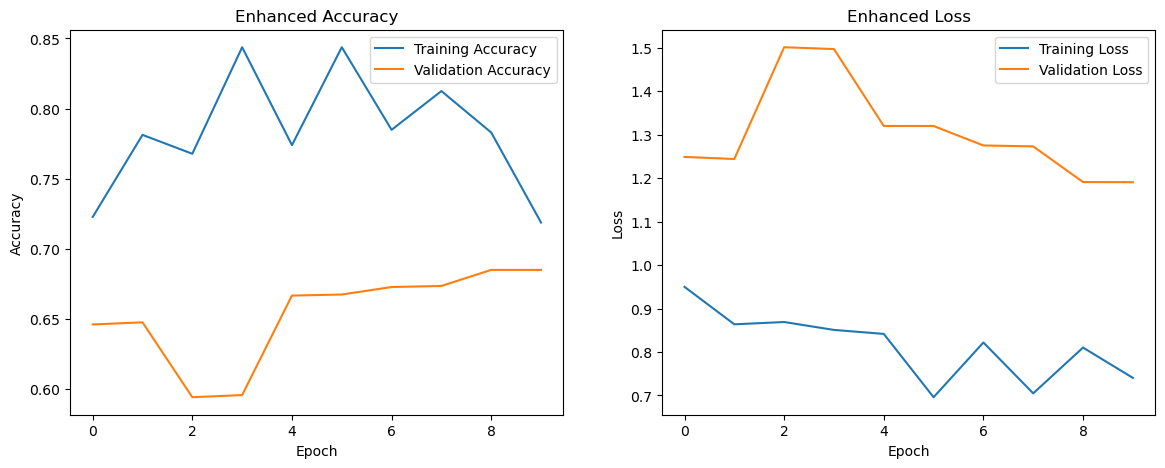

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step
Classification Report for Enhanced Images:
              precision    recall  f1-score   support

      glioma       0.89      0.47      0.61       300
  meningioma       0.85      0.22      0.34       306
     notumor       0.91      0.84      0.88       405
   pituitary       0.43      1.00      0.60       300

    accuracy                           0.65      1311
   macro avg       0.77      0.63      0.61      1311
weighted avg       0.78      0.65      0.63      1311



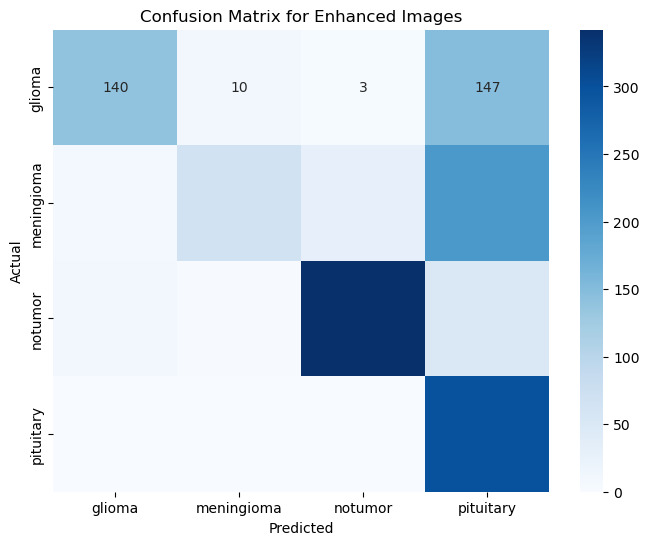

In [68]:

history_enhanced = model.fit(
    datagen.flow(x_train_enhanced, y_train, batch_size=32),
    validation_data=(x_test_enhanced, y_test),
    epochs=50,
    steps_per_epoch=len(x_train_enhanced) // 32,
    callbacks=callbacks,
    verbose=1
)

plot_training_history(history_enhanced)


y_pred_enhanced = np.argmax(model.predict(x_test_enhanced), axis=1)
y_true_enhanced = np.argmax(y_test, axis=1)

print("Classification Report for Enhanced Images:")
print(classification_report(y_true_enhanced, y_pred_enhanced, target_names=['glioma', 'meningioma', 'notumor', 'pituitary']))


cm_enhanced = confusion_matrix(y_true_enhanced, y_pred_enhanced)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_enhanced, annot=True, fmt='d', cmap='Blues', xticklabels=['glioma', 'meningioma', 'notumor', 'pituitary'], yticklabels=['glioma', 'meningioma', 'notumor', 'pituitary'])
plt.title('Confusion Matrix for Enhanced Images')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [7]:
def ensure_rgb(images):
    if len(images.shape) == 3:
        images = tf.expand_dims(images, axis=-1)
        images = tf.image.grayscale_to_rgb(images)
    elif images.shape[-1] == 3:
        pass
    else:
        raise ValueError(f"Unexpected image shape: {images.shape}")
    return images

x_train = tf.cast(ensure_rgb(x_train), tf.float32) / 255.0
x_test  = tf.cast(ensure_rgb(x_test),  tf.float32) / 255.0

In [8]:
input_shape = (128, 128, 3)
inputs = Input(shape=input_shape)

base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=inputs
)
base_model.trainable = False

In [10]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(4, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [11]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    batch_size=32
)

In [13]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    batch_size=32
)

Epoch 1/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 51s 275ms/step - accuracy: 0.2842 - loss: 1.4520 - val_accuracy: 0.4462 - val_loss: 1.2623
Epoch 2/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 49s 274ms/step - accuracy: 0.4019 - loss: 1.2757 - val_accuracy: 0.4889 - val_loss: 1.2131
Epoch 3/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 50s 280ms/step - accuracy: 0.4413 - loss: 1.2150 - val_accuracy: 0.5294 - val_loss: 1.1852
Epoch 4/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 50s 279ms/step - accuracy: 0.4739 - loss: 1.1554 - val_accuracy: 0.5072 - val_loss: 1.1622
Epoch 5/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 50s 279ms/step - accuracy: 0.4987 - loss: 1.1374 - val_accuracy: 0.5339 - val_loss: 1.1366
Epoch 6/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 50s 278ms/step - accuracy: 0.5241 - loss: 1.1056 - val_accuracy: 0.5652 - val_loss: 1.1089
Epoch 7/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 51s 283ms/step - accuracy: 0.5520 - loss: 1.0728 - val_accuracy: 0.5599 - val_loss: 1.0960
Epoch 8/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 51s 283ms/step - accuracy: 0.5319 -

In [18]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)  
y_true = np.argmax(y_test, axis=1) 

41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 247ms/step


In [19]:
cm = confusion_matrix(y_true, y_pred_classes)

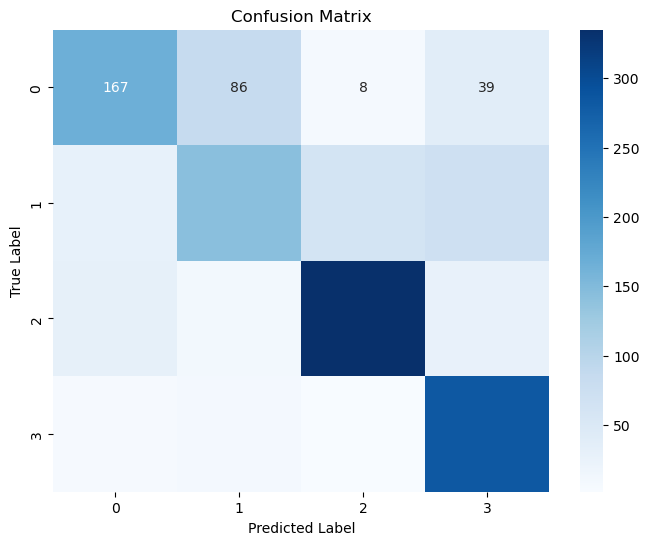

In [20]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [21]:
print("Classification Report:\n", classification_report(y_true, y_pred_classes))

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.56      0.63       300
           1       0.57      0.47      0.52       306
           2       0.82      0.83      0.83       405
           3       0.67      0.94      0.78       300

    accuracy                           0.71      1311
   macro avg       0.70      0.70      0.69      1311
weighted avg       0.71      0.71      0.70      1311



In [58]:
tf.keras.backend.clear_session()

In [69]:
img_shape = (299, 299)
BATCH_SIZE = 32
num_classes = 4
inputs = Input(shape=img_shape)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.1
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_shape,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_shape,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_shape,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 5143 images belonging to 4 classes.
Found 569 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [70]:
base_model = Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(299, 299, 3),
    pooling='max'
)
base_model.trainable = False

model = Sequential([
    base_model,
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(4, activation='softmax')
])

model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

In [72]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=30
)

Epoch 1/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 303s 2s/step - accuracy: 0.5903 - loss: 1.2352 - precision: 0.6328 - recall: 0.5134 - val_accuracy: 0.7469 - val_loss: 0.6885 - val_precision: 0.8073 - val_recall: 0.6995
Epoch 2/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 314s 2s/step - accuracy: 0.7980 - loss: 0.5159 - precision: 0.8362 - recall: 0.7512 - val_accuracy: 0.7627 - val_loss: 0.6048 - val_precision: 0.7895 - val_recall: 0.7381
Epoch 3/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 319s 2s/step - accuracy: 0.8187 - loss: 0.4769 - precision: 0.8482 - recall: 0.7836 - val_accuracy: 0.8313 - val_loss: 0.4721 - val_precision: 0.8553 - val_recall: 0.7996
Epoch 4/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 288s 2s/step - accuracy: 0.8442 - loss: 0.4146 - precision: 0.8642 - recall: 0.8159 - val_accuracy: 0.8278 - val_loss: 0.5166 - val_precision: 0.8404 - val_recall: 0.7961
Epoch 5/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 254s 2s/step - accuracy: 0.8699 - loss: 0.3514 - precision: 0.8860 - recall: 0.8526 - val_accuracy: 0.8401 - val_los

In [73]:
results = model.evaluate(test_data)
print("Test Results:", results)

41/41 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.9122 - loss: 0.2289 - precision: 0.9200 - recall: 0.9020
Test Results: [0.19746778905391693, 0.9282990097999573, 0.9355089068412781, 0.9183829426765442]


In [74]:
base_model.trainable = True
model.compile(
    optimizer=Adamax(learning_rate=0.0001), 
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)
fine_tune_history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20 
)

Epoch 1/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 1417s 9s/step - accuracy: 0.8297 - loss: 0.5323 - precision_1: 0.8432 - recall_1: 0.8125 - val_accuracy: 0.8049 - val_loss: 0.5363 - val_precision_1: 0.8240 - val_recall_1: 0.7979
Epoch 2/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 1413s 9s/step - accuracy: 0.9357 - loss: 0.1668 - precision_1: 0.9414 - recall_1: 0.9313 - val_accuracy: 0.8366 - val_loss: 0.4367 - val_precision_1: 0.8569 - val_recall_1: 0.8102
Epoch 3/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 6547s 41s/step - accuracy: 0.9530 - loss: 0.1201 - precision_1: 0.9577 - recall_1: 0.9477 - val_accuracy: 0.9104 - val_loss: 0.2676 - val_precision_1: 0.9146 - val_recall_1: 0.9033
Epoch 4/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 1732s 11s/step - accuracy: 0.9746 - loss: 0.0796 - precision_1: 0.9764 - recall_1: 0.9733 - val_accuracy: 0.9525 - val_loss: 0.1422 - val_precision_1: 0.9573 - val_recall_1: 0.9455
Epoch 5/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 1333s 8s/step - accuracy: 0.9805 - loss: 0.0588 - precision_1: 0.9805 - recall

In [76]:
preds = model.predict(test_data)
y_pred = np.argmax(preds, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step


In [78]:
clr = classification_report(y_true, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       300
           1       0.99      0.99      0.99       306
           2       1.00      1.00      1.00       405
           3       0.99      1.00      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311

